In [1]:
import geopandas
import pystac
import stac2dcache

from shapely.geometry import MultiPolygon, shape

# Create STAC catalog for shadow-enhanced assets

In [2]:
# DCACHE_API_URL = "https://dcacheview.grid.surfsara.nl:22880/api/v1"
DCACHE_WEBDAV_URL = "https://webdav.grid.surfsara.nl:2880"

In [3]:
dcache_root = (DCACHE_WEBDAV_URL  
    + "/pnfs/grid.sara.nl/data/eratosthenes/disk/")

# input catalog with sentinel-2 scenes
catalog_url = dcache_root + "red-glacier_sentinel-2"
collection_id = "sentinel-s2-l1c"

# RGI shapefile and ID
rgi_shape_url = dcache_root + "GIS/Glacier/01_rgi60_Alaska.zip"
rgi_id = "RGI60-01.19773"  # RGI ID of the Red Glacier

# output catalog with shadow-enhanced images
new_catalog_id = "red-glacier_sentinel-2_shadows"
new_catalog_url = dcache_root + new_catalog_id

In [4]:
# configure connection to dCache
dcache = stac2dcache.configure(
    filesystem="dcache", 
    token_filename="macaroon.dat"
)
# dcache.api_url = DCACHE_API_URL

In [5]:
def read_catalog(url):
    """
    Read STAC catalog from URL
    
    :param url: urlpath to the catalog root
    :return: PySTAC Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url)
    return catalog

In [6]:
# read image catalog
catalog = read_catalog(catalog_url)
subcatalog = catalog.get_child(collection_id)

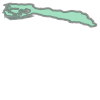

In [7]:
# get Red Glacier geometry from the RGI
with dcache.open(rgi_shape_url) as f:
    glaciers = geopandas.read_file(f)
    
red_glacier = glaciers[glaciers["RGIId"] == rgi_id]
red_glacier_geom = red_glacier.geometry.item()

red_glacier_geom

In [8]:
items = {}

# loop over items of image catalog
for item in subcatalog.get_all_items():
    
    # only scenes that intersect glacier's geometry
    geom = shape(item.geometry)
    if not geom.intersects(red_glacier_geom):
        continue
        
    item_new = item.clone()
        
    # remove assets and links
    item_new.assets = {}
    item_new.clear_links()

    # add links to downloaded scene and original collection
    names = ("computed_from", "original_collection")
    targets = (item, item.get_links("collection").pop().target)
    for name, target in zip(names, targets):
        link = pystac.Link(name, target)
        item_new.add_link(link)

    items[item_new.id] = item_new
        
len(items)

396

In [9]:
# spatial extent
footprints = (shape(i.geometry).envelope for i in items.values())
collection_bbox = MultiPolygon(footprints).bounds
spatial_extent = pystac.SpatialExtent(bboxes=[collection_bbox])

# temporal extent
start = (item.datetime for item in items.values())
start = sorted(start)[0]
end = (item.datetime for item in items.values())
end = sorted(end)[-1]
temporal_extent = pystac.TemporalExtent(intervals=[[start, end]])

extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)

In [10]:
# create collection object
collection = pystac.Collection(
    id=collection_id,
    description=("Collection of items derived from Sentinel-2 L1C scenes"),
    extent=extent,
)

collection.add_items(items.values())
collection

<Collection id=sentinel-s2-l1c>

In [11]:
# create output catalog
catalog = pystac.Catalog(
    id=new_catalog_id,
    description=("Catalog of shadow-enhanced images for the "
                 "Red Glacier (Alaska) and related assets")
)

catalog.add_child(collection)

In [12]:
template = "${year}/${month}/${day}"
_ = catalog.generate_subcatalogs(template)

In [13]:
catalog.describe()

* <Catalog id=red-glacier_sentinel-2_shadows>
    * <Collection id=sentinel-s2-l1c>
        * <Catalog id=2021>
            * <Catalog id=3>
                * <Catalog id=26>
                  * <Item id=S2B_5VMG_20210326_0_L1C>
                * <Catalog id=23>
                  * <Item id=S2B_5VMG_20210323_0_L1C>
                * <Catalog id=21>
                  * <Item id=S2A_5VMG_20210321_0_L1C>
                * <Catalog id=18>
                  * <Item id=S2A_5VMG_20210318_0_L1C>
                * <Catalog id=16>
                  * <Item id=S2B_5VMG_20210316_0_L1C>
                * <Catalog id=13>
                  * <Item id=S2B_5VMG_20210313_0_L1C>
                * <Catalog id=11>
                  * <Item id=S2A_5VMG_20210311_0_L1C>
                * <Catalog id=8>
                  * <Item id=S2A_5VMG_20210308_0_L1C>
                * <Catalog id=6>
                  * <Item id=S2B_5VMG_20210306_0_L1C>
                * <Catalog id=3>
                  * <Item id=S2B_5VM

In [14]:
# save it on dCache
catalog.normalize_and_save(
    new_catalog_url, 
    catalog_type="SELF_CONTAINED"
)